# Notebook Imports


In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

# Reading Data

In [94]:
df = pd.read_csv("cleaned_data.csv", index_col=0)
df = df.drop(columns=["title"])
df.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,T


# Splitting Dataset


In [95]:
encoding = {"E": 0, "ET": 1, "T": 2, "M": 3}
df.esrb_rating = df.esrb_rating.replace(encoding)

In [96]:
train, val = train_test_split(df, test_size=0.2)


# Data Cleaning

In our data we have a lot of explanatory variables, some of which are possibly not highly correlated with the explanatory variable, and hence would end up causing bias in our bias
 

For this reason, we can remove the variables which are not correlated with the explanatory variable. 

The following cells lists down the variables sorted in ascending order of absolute value of correlation with esrb_rating

In [97]:
train.corr().esrb_rating.sort_values(key= lambda x: abs(x))

animated_blood             -0.001636
console                     0.005874
mild_suggestive_themes      0.015197
cartoon_violence           -0.018945
mild_violence              -0.023313
fantasy_violence           -0.033553
use_of_alcohol              0.034962
use_of_drugs_and_alcohol    0.038766
mature_humor                0.038914
mild_blood                  0.043810
crude_humor                 0.045714
mild_lyrics                -0.052204
nudity                      0.061775
alcohol_reference          -0.084491
mild_language              -0.095508
lyrics                      0.116233
mild_cartoon_violence      -0.116917
drug_reference              0.118041
partial_nudity              0.128551
violence                    0.149196
suggestive_themes           0.161086
sexual_content              0.182715
language                    0.192881
simulated_gambling          0.202632
strong_sexual_content       0.246131
intense_violence            0.260091
sexual_themes               0.263669
m

We remove the variables with abs(correlation) < 0.2

In [98]:
columns_to_drop = train.columns[
    train.corr().esrb_rating.sort_values(key=lambda x: abs(x)) < 0.15
]

train = train.drop(columns=columns_to_drop)
train.head()


,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,esrb_rating
1009,0,0,0,0,0,0,0,0,0,0,1
439,0,0,0,0,0,0,0,0,0,0,1
361,0,0,0,0,0,0,0,0,0,0,2
48,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,2


Printing the new correlation matrix


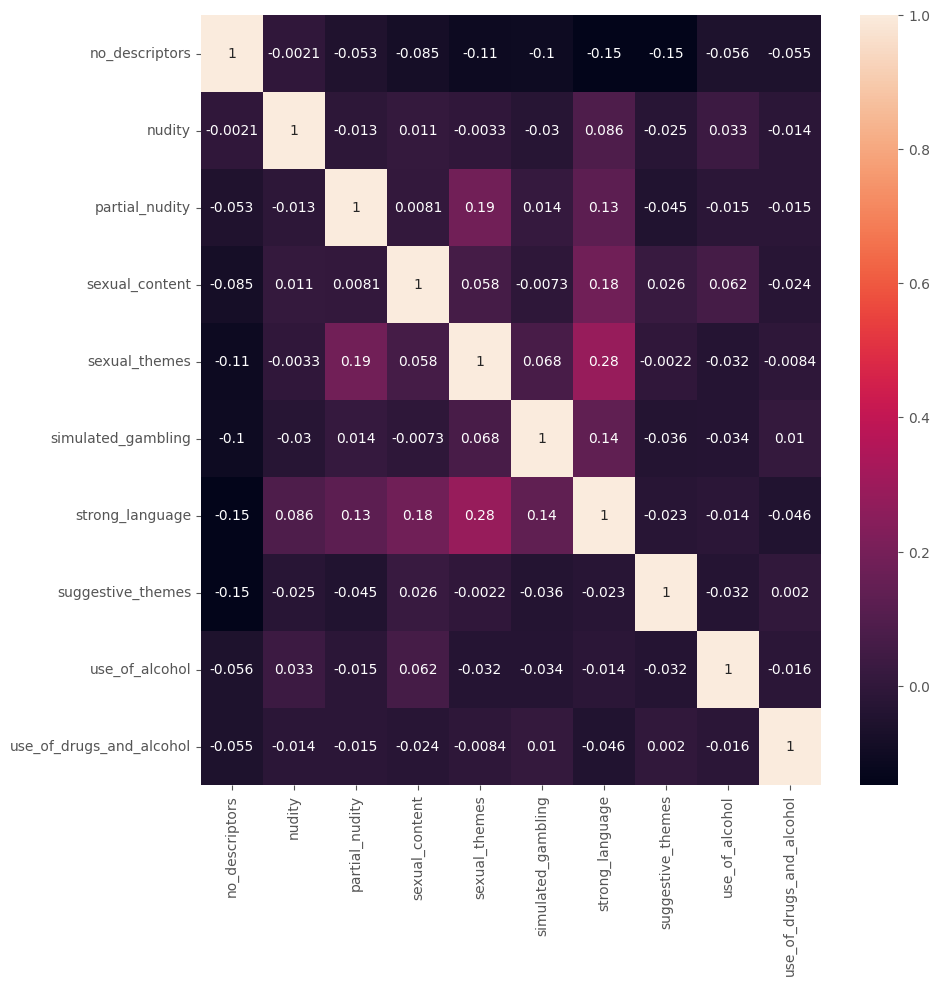

In [99]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.drop(columns="esrb_rating").corr(), annot=True)
plt.show()